In [2]:
# LBPH Webcam Enroll + Verify (Notebook) — with Mask + Threshold Tuning
# --------------------------------------------------------------------
# Requirements: pip install opencv-contrib-python
# How to use (after running this cell): in a new cell, call: run_app()
#
# Keys in the camera window:
#   E : Enroll mode (press S to capture; aim for ~10 shots)
#   S : Save one enrollment shot (only in Enroll mode)
#   V : Verify mode (live)
#   P : Record POS distance (authorized person in frame)
#   N : Record NEG distance (other person in frame)
#   C : Compute & apply suggested threshold τ* (EER-like)
#   K : Save collected distances -> pos_dists.npy / neg_dists.npy
#   T : Toggle small-face mode (detect smaller/farther faces)
#   + / - : Increase / Decrease threshold τ
#   W : Write model to lbph_model.xml
#   R : Read model from lbph_model.xml
#   Q : Quit

import cv2, numpy as np, os

# -------- Configuration --------
N_ENROLL        = 10                  # number of enrollment shots
FACE_SIZE       = (112, 112)         # aligned crop size
THRESH_INIT     = 60.0               # starting LBPH distance threshold
GRID_XY         = (8, 8)             # LBPH grid (x, y)

# Quality gates
MIN_FACE_PX     = 100
BLUR_VAR_MIN    = 80.0
BRIGHT_MINMAX   = (40, 210)

# Haar (default) detection params
HAAR_SCALE      = 1.20
HAAR_NEIGHBORS  = 5
HAAR_MINSIZE    = MIN_FACE_PX
UPSCALE         = 1.0

# Haar "small-face mode" (more sensitive; detects smaller/farther faces)
SMALL_HAAR_SCALE     = 1.05
SMALL_HAAR_NEIGHBORS = 3
SMALL_HAAR_MINSIZE   = 40
SMALL_UPSCALE        = 1.5

# Paths
MODEL_PATH      = "lbph_model.xml"
POS_PATH        = "pos_dists.npy"
NEG_PATH        = "neg_dists.npy"

# -------- Sanity check for opencv-contrib --------
def _check_contrib():
    if not hasattr(cv2, "face"):
        raise ImportError("cv2.face not found. Install with: pip install opencv-contrib-python")

# -------- Utilities --------
def _laplacian_var(img_gray):
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

def _quality_ok(face_gray):
    blur = _laplacian_var(face_gray)
    mean_brightness = float(np.mean(face_gray))
    bright_ok = BRIGHT_MINMAX[0] <= mean_brightness <= BRIGHT_MINMAX[1]
    return (blur >= BLUR_VAR_MIN) and bright_ok, blur, mean_brightness

def _apply_ellipse_mask(img_gray):
    """Elliptical mask to emphasize central face, reduce background/hair influence."""
    h, w = img_gray.shape
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    center = (w//2, h//2)
    axes = (int(w*0.45), int(h*0.60))   # oval roughly covering a face
    cv2.ellipse(mask, center, axes, 0, 0, 360, 255, -1)
    return cv2.bitwise_and(img_gray, mask)

def _preprocess(face_gray):
    # Resize + CLAHE for lighting normalization, then apply elliptical mask
    face = cv2.resize(face_gray, FACE_SIZE, interpolation=cv2.INTER_AREA)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    face = clahe.apply(face)
    face = _apply_ellipse_mask(face)
    return face

def _detect_largest_face(gray, cascade, scaleFactor, minNeighbors, minSize, upscale=1.0):
    # Optional upsample for detection (helps with small/distant faces)
    if upscale != 1.0:
        gray_up = cv2.resize(gray, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_LINEAR)
    else:
        gray_up = gray

    faces = cascade.detectMultiScale(
        gray_up,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        flags=cv2.CASCADE_SCALE_IMAGE,
        minSize=(minSize, minSize)
    )
    if len(faces) == 0:
        return None

    x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

    # Map coords back if upscaled
    if upscale != 1.0:
        x = int(x / upscale); y = int(y / upscale)
        w = int(w / upscale); h = int(h / upscale)
    return (x, y, w, h)

def _put_text_block(frame, lines, org=(10, 26)):
    x, y = org
    for i, txt in enumerate(lines):
        cv2.putText(frame, txt, (x, y + 24 * i), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(frame, txt, (x, y + 24 * i), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)

# -------- Threshold suggestion (EER-like) --------
def _suggest_threshold(pos, neg):
    """
    Suggest a threshold τ* by minimizing max(FNR, FAR) over candidate thresholds.
    pos: distances for genuine (same person)
    neg: distances for impostors (other people)
    """
    pos = np.asarray(pos, dtype=float)
    neg = np.asarray(neg, dtype=float)
    if pos.size == 0 or neg.size == 0:
        return None, None, None

    candidates = np.unique(np.concatenate([pos, neg]))
    if candidates.size < 3:
        # Fallback: midpoint of medians
        t = 0.5 * (np.median(pos) + np.median(neg))
        fnr = np.mean(pos > t) if pos.size else 0.0
        far = np.mean(neg <= t) if neg.size else 0.0
        return float(t), float(fnr), float(far)

    best_t, best_score, best_fnr, best_far = None, 1e9, None, None
    for t in candidates:
        fnr = np.mean(pos > t)   # genuine rejected
        far = np.mean(neg <= t)  # impostor accepted
        score = max(fnr, far)
        if score < best_score:
            best_score, best_t, best_fnr, best_far = score, t, fnr, far

    return float(best_t), float(best_fnr), float(best_far)

# -------- App --------
def run_app():
    """
    Webcam app:
      E: Enroll (S to capture shots)
      V: Verify
      P: Record POS distance (authorized person)
      N: Record NEG distance (other person)
      C: Compute/apply suggested τ*
      K: Save distances -> pos_dists.npy / neg_dists.npy
      T: Toggle small-face mode
      + / - : Adjust τ manually
      W: Save model  (lbph_model.xml)
      R: Load model  (lbph_model.xml)
      Q: Quit
    """
    _check_contrib()

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    if face_cascade.empty():
        raise RuntimeError("Failed to load Haar cascade.")

    model = cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=8, grid_x=GRID_XY[0], grid_y=GRID_XY[1])

    # State
    enrolled_imgs, labels = [], []
    trained = False
    mode = "idle"
    tau = float(THRESH_INIT)
    small_mode = False
    info = "E,S,V,P,N,C,K,T,+,-,W,R,Q"

    # Tuning buffers
    pos_dists, neg_dists = [], []
    last_dist = None
    last_suggest = None  # (t, fnr, far)

    # Detection params (current)
    cur_scale, cur_neighbors, cur_minsize, cur_upscale = HAAR_SCALE, HAAR_NEIGHBORS, HAAR_MINSIZE, UPSCALE

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("❌ Could not open camera.")

    print("Controls: E=enroll, S=save, V=verify, P/N add samples, C suggest τ, K save dists, T small-face, +/- τ, W/R save/load, Q quit")

    while True:
        ok, frame = cap.read()
        if not ok:
            print("❌ Camera read failed.")
            break
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        face_box = _detect_largest_face(gray, face_cascade, cur_scale, cur_neighbors, cur_minsize, cur_upscale)
        if face_box is not None:
            x, y, w, h = face_box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 180, 255), 2)

        header = [
            f"Mode: {mode.upper()}   τ={tau:.1f}   Small-face: {'ON' if small_mode else 'OFF'}",
            "Keys: " + info
        ]
        _put_text_block(frame, header, org=(10, 26))

        tune_lines = [f"POS:{len(pos_dists)}  NEG:{len(neg_dists)}"]
        if last_suggest is not None:
            t, fnr, far = last_suggest
            tune_lines.append(f"τ*={t:.1f} (FNR={fnr:.2f}, FAR={far:.2f})")
        _put_text_block(frame, tune_lines, org=(10, 75))

        if mode == "enroll":
            _put_text_block(frame, [f"ENROLL: Press S to capture   {len(enrolled_imgs)}/{N_ENROLL}"], org=(10, 110))

        elif mode == "verify" and trained and face_box is not None:
            x, y, w, h = face_box
            roi = gray[y:y + h, x:x + w]
            probe = _preprocess(roi)
            label, dist = model.predict(probe)  # lower = more similar
            last_dist = float(dist)
            verdict = (label == 0) and (dist <= tau)
            tag = f"{'ACCEPT' if verdict else 'REJECT'}  dist={dist:.1f}"
            color = (0, 200, 0) if verdict else (0, 0, 255)
            cv2.putText(frame, tag, (x, max(0, y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
        elif mode == "verify" and not trained:
            _put_text_block(frame, ["Model not trained/loaded. E to enroll or R to load."], org=(10, 110))

        cv2.imshow("LBPH 1:1 Verify (Haar, Mask, Tuning)", frame)
        k = cv2.waitKey(1) & 0xFF

        if k == ord('q'):
            break

        elif k == ord('e'):
            enrolled_imgs.clear(); labels.clear()
            trained = False
            mode = "enroll"
            info = "Enrollment: Press S to capture each shot."

        elif k == ord('s') and mode == "enroll":
            if face_box is None:
                info = "No face detected. Move closer/lighting."
                continue
            x, y, w, h = face_box
            roi = gray[y:y + h, x:x + w]
            okq, blur, meanb = _quality_ok(roi)
            if not okq:
                info = f"Shot rejected (blur={blur:.0f}, mean={meanb:.0f}). Try again."
                continue
            enrolled_imgs.append(_preprocess(roi)); labels.append(0)
            if len(enrolled_imgs) >= N_ENROLL:
                model.train(enrolled_imgs, np.array(labels))
                trained = True
                mode = "verify"
                info = f"Training complete ({len(enrolled_imgs)} shots). Switched to VERIFY."
            else:
                info = f"Captured {len(enrolled_imgs)}/{N_ENROLL}"

        elif k == ord('v'):
            mode = "verify"; info = "Verify mode."

        elif k == ord('w'):
            if trained:
                model.write(MODEL_PATH)
                info = f"Model saved to {MODEL_PATH}"
            else:
                info = "Nothing to save yet."

        elif k == ord('r'):
            if os.path.exists(MODEL_PATH):
                model.read(MODEL_PATH)
                trained = True
                mode = "verify"
                info = f"Model loaded from {MODEL_PATH}. Verify mode."
            else:
                info = f"No {MODEL_PATH} found."

        elif k == ord('t'):
            small_mode = not small_mode
            if small_mode:
                cur_scale, cur_neighbors, cur_minsize, cur_upscale = (
                    SMALL_HAAR_SCALE, SMALL_HAAR_NEIGHBORS, SMALL_HAAR_MINSIZE, SMALL_UPSCALE
                )
                info = "Small-face mode ON (more sensitive)."
            else:
                cur_scale, cur_neighbors, cur_minsize, cur_upscale = (
                    HAAR_SCALE, HAAR_NEIGHBORS, HAAR_MINSIZE, UPSCALE
                )
                info = "Small-face mode OFF."

        elif k == ord('+') or k == ord('='):
            tau += 2.0; info = f"τ -> {tau:.1f}"

        elif k == ord('-') or k == ord('_'):
            tau = max(2.0, tau - 2.0); info = f"τ -> {tau:.1f}"

        # --- Threshold tuning: record/apply ---
        elif k == ord('p'):  # record positive distance
            if mode == "verify" and last_dist is not None:
                pos_dists.append(last_dist)
                info = f"POS recorded: {last_dist:.1f}  (total {len(pos_dists)})"
            else:
                info = "Switch to VERIFY and ensure face is detected."

        elif k == ord('n'):  # record negative distance
            if mode == "verify" and last_dist is not None:
                neg_dists.append(last_dist)
                info = f"NEG recorded: {last_dist:.1f}  (total {len(neg_dists)})"
            else:
                info = "Switch to VERIFY and ensure face is detected."

        elif k == ord('c'):  # compute suggestion
            if len(pos_dists) >= 3 and len(neg_dists) >= 3:
                t, fnr, far = _suggest_threshold(pos_dists, neg_dists)
                if t is not None:
                    tau = t
                    last_suggest = (t, fnr, far)
                    info = f"τ*={t:.1f} applied (FNR={fnr:.2f}, FAR={far:.2f})."
                else:
                    info = "Not enough data to suggest τ."
            else:
                info = "Need ≥3 POS and ≥3 NEG samples to suggest τ."

        elif k == ord('k'):  # save distances
            if len(pos_dists):
                np.save(POS_PATH, np.array(pos_dists, dtype=float))
            if len(neg_dists):
                np.save(NEG_PATH, np.array(neg_dists, dtype=float))
            info = f"Saved -> {POS_PATH if len(pos_dists) else ''} {NEG_PATH if len(neg_dists) else ''}"

    cap.release()
    cv2.destroyAllWindows()

# In a new cell, call:
# run_app()


In [3]:
run_app()

ImportError: cv2.face not found. Install with: pip install opencv-contrib-python

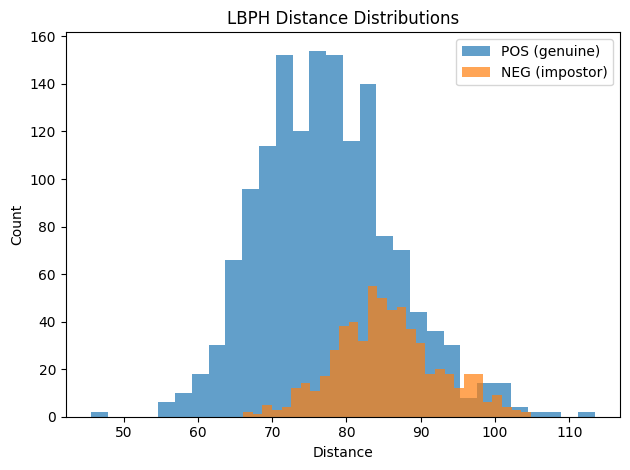

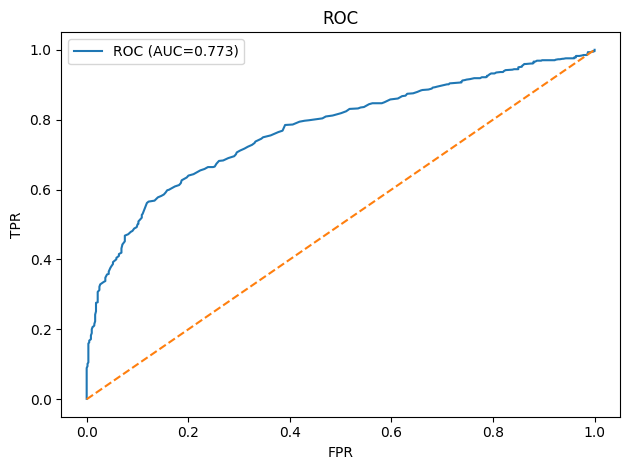

AUC = 0.7728

✔ Used identities: 31  |  POS=1478  NEG=599  |  Skipped images=60
τ* (near EER) = 81.86   |   EER ≈ 0.296
At τ*: TP=1040  FN=438  FP=177  TN=422  (total=2077)
            accuracy: 0.7039
           precision: 0.8546
          recall_TPR: 0.7037
     specificity_TNR: 0.7045
                  F1: 0.7718
             FAR_FPR: 0.2955
                 FRR: 0.2963
   balanced_accuracy: 0.7041

Performance Metrics Table:
 Operating Point  Threshold (tau)  Accuracy  Precision  Recall (TPR)  Specificity (TNR)       F1  FAR (FPR)      FRR  Balanced Accuracy   TP   FN  FP  TN
     τ* near EER        81.840321  0.703900   0.854560      0.703654           0.704508 0.771800   0.295492 0.296346           0.704081 1040  438 177 422
Max Balanced Acc        78.074060  0.655753   0.919692      0.565629           0.878130 0.700461   0.121870 0.434371           0.721880  836  642  73 526
    Max Accuracy        83.638625  0.734232   0.832138      0.784844           0.609349 0.807799   0.3906

In [20]:
# LBPH eval on train/val/test splits — small-face Haar + round-face mask
# ---------------------------------------------------------------------
# Requires: pip install opencv-contrib-python numpy matplotlib pandas
# Set DATA_ROOT to the folder that contains train/, val/, test/

import os, glob, random, math, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# ---------------- Config ----------------
DATA_ROOT        = r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data\data_proc"   # <-- CHANGE to your root that has train/, val/, test/
ENROLL_K         = 5                  # max enroll imgs per ID (from train); adapts per-ID
NEG_PER_ID       = 20                 # impostor probes sampled per ID
USE_DETECTION    = True               # set False if faces are already tightly cropped
SMALL_FACE_MODE  = True               # more sensitive Haar + 1.5x upsample
OUT_DIR          = "lbph_eval_out"    # outputs only (dataset never modified)

# LBP / detection params
FACE_SIZE        = (112, 112)
GRID_XY          = (8, 8)
RANDOM_SEED      = 42
SHRINK_FRAC      = 0.10
UPSCALE_DEFAULT  = 1.0
UPSCALE_SMALL    = 1.5
HAAR_SCALE, HAAR_NEIGHBORS, HAAR_MINSIZE = 1.20, 5, 100
SMALL_HAAR_SCALE, SMALL_HAAR_NEIGHBORS, SMALL_HAAR_MINSIZE = 1.05, 3, 40
USE_CLAHE, USE_MASK = True, True

# ---------------- Utils ----------------
def _ensure_contrib():
    if not hasattr(cv2, "face"):
        raise ImportError("cv2.face not found. Install with: pip install opencv-contrib-python")

def _ensure_outdir(path):
    os.makedirs(path, exist_ok=True)

def _ellipse_mask(img_gray):
    h, w = img_gray.shape
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    center = (w//2, h//2)
    axes = (int(w*0.45), int(h*0.60))
    cv2.ellipse(mask, center, axes, 0, 0, 360, 255, -1)
    return cv2.bitwise_and(img_gray, mask)

def _preprocess(face_gray):
    img = cv2.resize(face_gray, FACE_SIZE, interpolation=cv2.INTER_AREA)
    if USE_CLAHE:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
    if USE_MASK:
        img = _ellipse_mask(img)
    return img

def _shrink_box(x, y, w, h, frac=0.10):
    dx, dy = int(w*frac), int(h*frac)
    x2, y2 = x + dx, y + dy
    w2, h2 = w - 2*dx, h - 2*dy
    if w2 < 5 or h2 < 5:
        return x, y, w, h
    return x2, y2, w2, h2

def _detect_face(gray, cascade, scale, neigh, minsz, upscale=1.0):
    gray_up = cv2.resize(gray, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_LINEAR) if upscale!=1.0 else gray
    faces = cascade.detectMultiScale(
        gray_up, scaleFactor=scale, minNeighbors=neigh,
        flags=cv2.CASCADE_SCALE_IMAGE, minSize=(minsz, minsz)
    )
    if len(faces) == 0:
        return None
    x, y, w, h = max(faces, key=lambda b: b[2]*b[3])
    if upscale != 1.0:
        x = int(x/upscale); y = int(y/upscale); w = int(w/upscale); h = int(h/upscale)
    return (x, y, w, h)

def _detect_and_crop(img_bgr, cascade):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    box = _detect_face(gray, cascade, HAAR_SCALE, HAAR_NEIGHBORS, HAAR_MINSIZE, UPSCALE_DEFAULT)
    if box is None and SMALL_FACE_MODE:
        box = _detect_face(gray, cascade, SMALL_HAAR_SCALE, SMALL_HAAR_NEIGHBORS, SMALL_HAAR_MINSIZE, UPSCALE_SMALL)
    if box is None:
        return None
    x, y, w, h = _shrink_box(*box, frac=SHRINK_FRAC)
    return _preprocess(gray[y:y+h, x:x+w])

def _list_id_images(split_dir):
    """Return dict: id -> [filepaths] for a split folder (train/val/test)."""
    idx = {}
    if not os.path.isdir(split_dir):
        return idx
    for person in sorted(os.listdir(split_dir)):
        pdir = os.path.join(split_dir, person)
        if not os.path.isdir(pdir): 
            continue
        files = []
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.JPG","*.PNG"):
            files.extend(glob.glob(os.path.join(pdir, ext)))
        if files:
            idx[person] = sorted(files)
    return idx

# ---------------- Metrics ----------------
def _confusion(pos, neg, tau):
    TP = int(np.sum(pos <= tau)); FN = int(np.sum(pos > tau))
    FP = int(np.sum(neg <= tau)); TN = int(np.sum(neg > tau))
    return TP, FN, FP, TN

def _metrics(TP, FN, FP, TN):
    total = TP+FN+FP+TN
    accuracy = (TP+TN)/total if total else float('nan')
    precision = TP/(TP+FP) if (TP+FP) else float('nan')
    recall = TP/(TP+FN) if (TP+FN) else float('nan')          # TPR
    specificity = TN/(TN+FP) if (TN+FP) else float('nan')     # TNR
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else float('nan')
    FAR = FP/(FP+TN) if (FP+TN) else float('nan')             # FPR
    FRR = FN/(TP+FN) if (TP+FN) else float('nan')
    bal = 0.5*(recall + specificity) if (not math.isnan(recall) and not math.isnan(specificity)) else float('nan')
    return dict(accuracy=accuracy, precision=precision, recall_TPR=recall,
                specificity_TNR=specificity, F1=f1, FAR_FPR=FAR, FRR=FRR, balanced_accuracy=bal)

def _sweep(pos, neg, num=500):
    lo = min(pos.min(), neg.min()); hi = max(pos.max(), neg.max())
    taus = np.linspace(lo, hi, num=num)
    TPR, FPR = [], []
    for t in taus:
        TP, FN, FP, TN = _confusion(pos, neg, t)
        M = _metrics(TP, FN, FP, TN)
        TPR.append(M["recall_TPR"]); FPR.append(M["FAR_FPR"])
    return taus, np.array(TPR), np.array(FPR)

def _auc(x, y):
    order = np.argsort(x)
    return np.trapz(y[order], x[order])

def _suggest_tau_eer(pos, neg, num=1000):
    taus, tpr, fpr = _sweep(pos, neg, num=num)
    fnr = 1.0 - tpr
    i = int(np.argmin(np.abs(fnr - fpr)))
    return float(taus[i]), float(0.5*(fnr[i]+fpr[i]))

# ---------------- Core eval ----------------
def evaluate():
    """
    Enroll from train/, probe with val+test (fallback to leftover train if needed),
    compute metrics + table, save everything to OUT_DIR.
    """
    random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
    _ensure_contrib()
    _ensure_outdir(OUT_DIR)

    # Load splits
    train_idx = _list_id_images(os.path.join(DATA_ROOT, "train"))
    val_idx   = _list_id_images(os.path.join(DATA_ROOT, "val"))
    test_idx  = _list_id_images(os.path.join(DATA_ROOT, "test"))

    if not train_idx:
        raise RuntimeError(f"No identities found under {DATA_ROOT}/train")
    # IDs we will evaluate: present in train AND (val or test)
    ids = [pid for pid in train_idx.keys() if (pid in val_idx or pid in test_idx)]
    if not ids:
        raise RuntimeError("No overlapping identities between train and (val|test).")

    # Haar
    cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    if cascade.empty():
        raise RuntimeError("Failed to load Haar cascade.")

    pos_dists, neg_dists = [], []
    used_ids, skipped = 0, 0

    for pid in ids:
        train_files = list(train_idx[pid])
        probe_files_pos = []
        if pid in val_idx:  probe_files_pos += val_idx[pid]
        if pid in test_idx: probe_files_pos += test_idx[pid]
        # Fallback: if val+test empty, use leftover train as probes
        if not probe_files_pos:
            probe_files_pos = train_files[ENROLL_K:] if len(train_files) > 1 else []
            if not probe_files_pos:
                continue

        # Enroll set from train (adaptive)
        random.shuffle(train_files)
        enroll_k_i = max(1, min(ENROLL_K, len(train_files)))
        enroll_files = train_files[:enroll_k_i]

        # Prepare enroll images
        enroll_imgs = []
        for fp in enroll_files:
            img = cv2.imread(fp)
            if img is None: skipped += 1; continue
            if USE_DETECTION:
                face = _detect_and_crop(img, cascade)
                if face is None: skipped += 1; continue
            else:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                face = _preprocess(gray)
            enroll_imgs.append(face)
        if len(enroll_imgs)==0:
            continue

        # Train per-ID LBPH
        model = cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=8, grid_x=GRID_XY[0], grid_y=GRID_XY[1])
        labels = np.zeros((len(enroll_imgs),), dtype=np.int32)
        model.train(enroll_imgs, labels)
        used_ids += 1

        # POS probes: val+test (or fallback leftover train)
        for fp in probe_files_pos:
            img = cv2.imread(fp)
            if img is None: skipped += 1; continue
            if USE_DETECTION:
                face = _detect_and_crop(img, cascade)
                if face is None: skipped += 1; continue
            else:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                face = _preprocess(gray)
            _, dist = model.predict(face)
            pos_dists.append(float(dist))

        # NEG probes: sample other identities from val+test (prefer), else from their train
        other_ids = [oid for oid in ids if oid != pid]
        neg_pool = []
        for oid in other_ids:
            neg_pool += val_idx.get(oid, [])[:3] + test_idx.get(oid, [])[:3]
        if not neg_pool:
            for oid in other_ids:
                neg_pool += train_idx.get(oid, [])[:2]
        random.shuffle(neg_pool)
        neg_pool = neg_pool[:NEG_PER_ID]

        for fp in neg_pool:
            img = cv2.imread(fp)
            if img is None: skipped += 1; continue
            if USE_DETECTION:
                face = _detect_and_crop(img, cascade)
                if face is None: skipped += 1; continue
            else:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                face = _preprocess(gray)
            _, dist = model.predict(face)
            neg_dists.append(float(dist))

    pos = np.array(pos_dists, dtype=float)
    neg = np.array(neg_dists, dtype=float)
    if len(pos)==0 or len(neg)==0:
        raise RuntimeError("Not enough POS/NEG distances. Check that test/val have images and detection succeeds (or set USE_DETECTION=False).")

    # --- Metrics at τ* and curves ---
    tau_star, eer = _suggest_tau_eer(pos, neg)
    TP, FN, FP, TN = _confusion(pos, neg, tau_star)
    M = _metrics(TP, FN, FP, TN)

    np.save(os.path.join(OUT_DIR, "pos_dists.npy"), pos)
    np.save(os.path.join(OUT_DIR, "neg_dists.npy"), neg)
    with open(os.path.join(OUT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
        json.dump({
            "tau_star": tau_star, "eer": eer,
            "TP": TP, "FN": FN, "FP": FP, "TN": TN,
            "metrics_at_tau_star": M,
            "used_identities": used_ids,
            "skipped_images": skipped,
            "config": dict(DATA_ROOT=DATA_ROOT, ENROLL_K=ENROLL_K, NEG_PER_ID=NEG_PER_ID,
                           USE_DETECTION=USE_DETECTION, SMALL_FACE_MODE=SMALL_FACE_MODE)
        }, f, indent=2)

    # Plots
    plt.figure()
    plt.hist(pos, bins=30, alpha=0.7, label="POS (genuine)")
    plt.hist(neg, bins=30, alpha=0.7, label="NEG (impostor)")
    plt.title("LBPH Distance Distributions"); plt.xlabel("Distance"); plt.ylabel("Count")
    plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "dists_hist.png")); plt.show()

    taus, tpr, fpr = _sweep(pos, neg, num=500)
    auc = _auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
    plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "roc.png")); plt.show()
    print(f"AUC = {auc:.4f}")

    # Metrics table (operating points)
    dense = []
    for t in np.linspace(min(pos.min(),neg.min()), max(pos.max(),neg.max()), 2000):
        TPx, FNx, FPx, TNx = _confusion(pos, neg, t)
        mx = _metrics(TPx, FNx, FPx, TNx); mx.update(dict(tau=t, TP=TPx, FN=FNx, FP=FPx, TN=TNx))
        dense.append(mx)
    df = pd.DataFrame(dense)

    # τ* near EER & maxima
    i_eer = int((1.0 - df["recall_TPR"] - df["FAR_FPR"]).abs().idxmin())
    rows = []
    def add_row(name, i):
        r = df.loc[i]
        rows.append({
            "Operating Point": name, "Threshold (tau)": float(r["tau"]),
            "Accuracy": float(r["accuracy"]), "Precision": float(r["precision"]),
            "Recall (TPR)": float(r["recall_TPR"]), "Specificity (TNR)": float(r["specificity_TNR"]),
            "F1": float(r["F1"]), "FAR (FPR)": float(r["FAR_FPR"]), "FRR": float(r["FRR"]),
            "Balanced Accuracy": float(r["balanced_accuracy"]),
            "TP": int(r["TP"]), "FN": int(r["FN"]), "FP": int(r["FP"]), "TN": int(r["TN"])
        })
    add_row("τ* near EER", i_eer)
    add_row("Max Balanced Acc", int(df["balanced_accuracy"].idxmax()))
    add_row("Max Accuracy", int(df["accuracy"].idxmax()))
    add_row("Max F1", int(df["F1"].idxmax()))
    cand = df[df["FAR_FPR"] <= 0.01]
    if len(cand):
        add_row("FAR ≤ 1%", int(cand["recall_TPR"].idxmax()))

    table = pd.DataFrame(rows, columns=[
        "Operating Point","Threshold (tau)","Accuracy","Precision","Recall (TPR)","Specificity (TNR)",
        "F1","FAR (FPR)","FRR","Balanced Accuracy","TP","FN","FP","TN"
    ])
    table.to_csv(os.path.join(OUT_DIR, "metrics_table.csv"), index=False)

    # Console summary
    print(f"\n✔ Used identities: {len(ids)}  |  POS={len(pos)}  NEG={len(neg)}  |  Skipped images={skipped}")
    print(f"τ* (near EER) = {tau_star:.2f}   |   EER ≈ {eer:.3f}")
    print(f"At τ*: TP={TP}  FN={FN}  FP={FP}  TN={TN}  (total={TP+FN+FP+TN})")
    for k in ["accuracy","precision","recall_TPR","specificity_TNR","F1","FAR_FPR","FRR","balanced_accuracy"]:
        print(f"{k:>20}: {M[k]:.4f}")
    print("\nPerformance Metrics Table:")
    print(table.to_string(index=False))
    print(f"\nOutputs saved to: {OUT_DIR}")
    return table

# ------- Run (defines + executes evaluate) -------
table_df = evaluate()
